In [ ]:
# We used Lung Cancer dataset avaiable on Kaggle, downloaded and uploaded it on Google Drive to run code in Google Colab
# Dataset Link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images 

In [2]:
# Downgrading tensorflow to 2.15 version for compatibility with tensorflow-addons
!pip install --upgrade tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [10]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Attention, Reshape
from tensorflow.keras.regularizers import l2
!pip install keras_self_attention
from keras_self_attention import SeqSelfAttention
import warnings

warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=360f103055ce6551d096ef437a4b0a117d8e717c5657f4a9048efada19857314
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [1]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset_dir = '/content/drive/MyDrive/lung_colon_image_set/lung_image_sets'

In [11]:
def data_loader(dataset_dir):
    image_file_paths = []
    classes = []
    folders = os.listdir(dataset_dir)

    for folder in folders:
        folder_path = os.path.join(dataset_dir, folder)
        image_file_list = os.listdir(folder_path)
        for image_file in image_file_list:
            path = os.path.join(folder_path, image_file)

            image_file_paths.append(path)
            classes.append(folder)

    df = pd.DataFrame({'image_file_path': image_file_paths, 'class': classes})

    return df

df = data_loader(dataset_dir)
df

,image_file_path,class
0,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_scc
1,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_scc
2,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_scc
3,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_scc
4,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_scc
...,...,...
14995,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_n
14996,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_n
14997,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_n
14998,/content/drive/MyDrive/lung_colon_image_set/lu...,lung_n


In [12]:
class_counts = df['class'].value_counts()
print(class_counts)

class
lung_scc    5000
lung_aca    5000
lung_n      5000
Name: count, dtype: int64


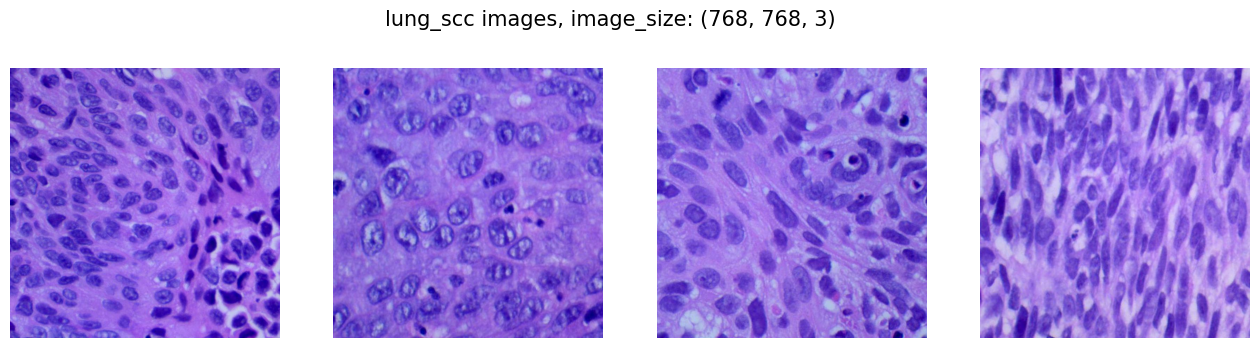

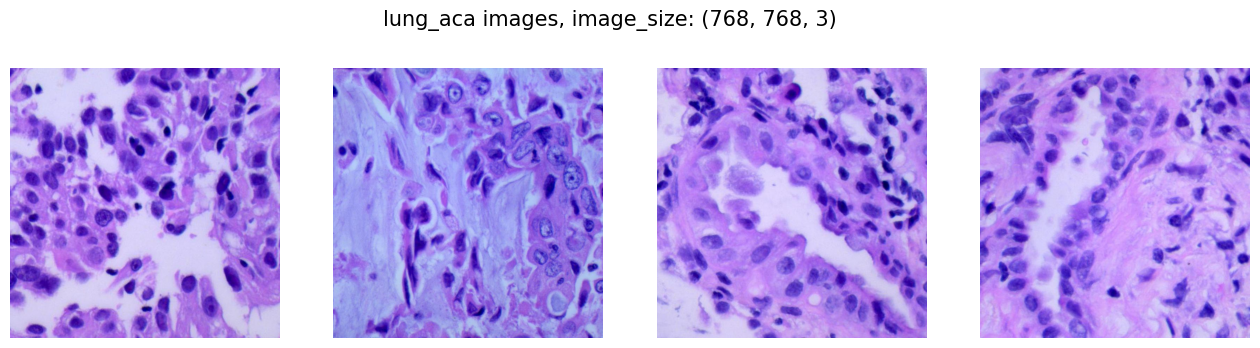

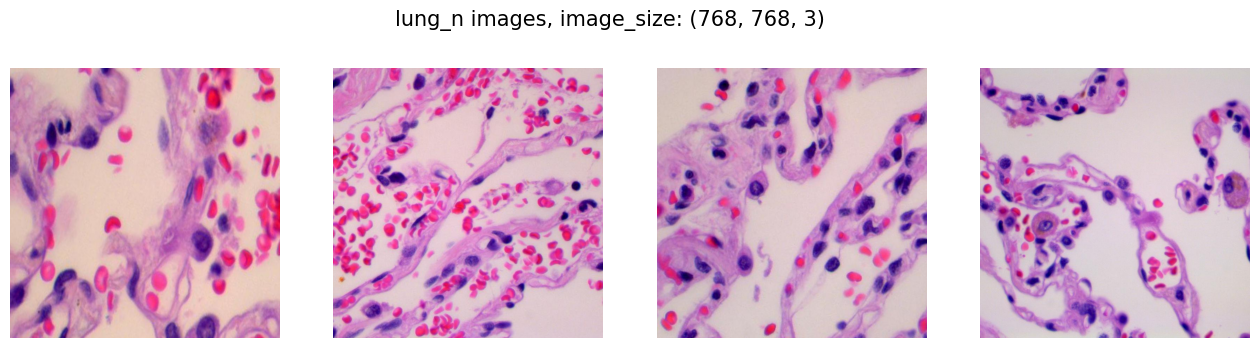

In [31]:
for class_name in class_counts.index:
    class_image_dir = f'{dataset_dir}/{class_name}'
    class_images = os.listdir(class_image_dir)

    fig, ax = plt.subplots(1, 4, figsize = (16, 4))

    k = 5
    for i in range(4):
        img = cv2.imread(f'{dataset_dir}/{class_name}/{class_images[k]}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis('off')
        k += 2

    fig.suptitle(f'{class_name} images, image_size: {img.shape}',
                 fontsize = 15)
    plt.show()

In [13]:
# Train-Validation-Test Split
train_df, validation_test_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 13)

validation_df, test_df = train_test_split(validation_test_df, train_size = 0.5, shuffle = True, random_state = 13)

In [14]:
train_df.shape, validation_df.shape, test_df.shape

((12000, 2), (1500, 2), (1500, 2))

In [15]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

train_datagen_2 = ImageDataGenerator(rescale=1./255, samplewise_center = True, samplewise_std_normalization = True)
validation_datagen_2 = ImageDataGenerator(rescale=1./255, samplewise_center = True, samplewise_std_normalization = True)
test_datagen_2 = ImageDataGenerator(rescale=1./255, samplewise_center = True, samplewise_std_normalization = True)

train_generator_2 = train_datagen_2.flow_from_dataframe(train_df, x_col= 'image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

validation_generator_2 = validation_datagen_2.flow_from_dataframe(validation_df, x_col='image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size=BATCH_SIZE)

test_generator_2 = test_datagen_2.flow_from_dataframe(test_df, x_col='image_file_path', y_col='class', target_size=(IMAGE_SIZE,IMAGE_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [4]:
!pip install --quiet vit-keras
from vit_keras import vit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00


In [16]:
from vit_keras import utils

vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 3
        )

353253686/353253686 [==============================] - 7s 0us/step


In [17]:
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [18]:
model_2 = Sequential()
model_2.add(vit_model)
model_2.add(Flatten())
model_2.add(Dropout(0.2))

model_2.add(Dense(64, activation="relu"))
model_2.add(Dense(32, activation="relu"))
model_2.add(Dense(16, activation="relu"))
model_2.add(Dense(3, activation="softmax"))

In [19]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 5

In [20]:
model_2.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [21]:
history_2 = model_2.fit(train_generator_2, epochs = 8, validation_data = validation_generator_2)

Epoch 1/8
188/188 [==============================] - 6243s 33s/step - loss: 0.2940 - accuracy: 0.8744 - val_loss: 0.1608 - val_accuracy: 0.9360
Epoch 2/8
188/188 [==============================] - 150s 796ms/step - loss: 0.1645 - accuracy: 0.9352 - val_loss: 0.1330 - val_accuracy: 0.9440
Epoch 3/8
188/188 [==============================] - 141s 750ms/step - loss: 0.1499 - accuracy: 0.9414 - val_loss: 0.3198 - val_accuracy: 0.8500
Epoch 4/8
188/188 [==============================] - 142s 751ms/step - loss: 0.1350 - accuracy: 0.9478 - val_loss: 0.1519 - val_accuracy: 0.9453
Epoch 5/8
188/188 [==============================] - 142s 752ms/step - loss: 0.1324 - accuracy: 0.9498 - val_loss: 0.1472 - val_accuracy: 0.9460
Epoch 6/8
188/188 [==============================] - 148s 786ms/step - loss: 0.1052 - accuracy: 0.9588 - val_loss: 0.2011 - val_accuracy: 0.9100
Epoch 7/8
188/188 [==============================] - 143s 756ms/step - loss: 0.0830 - accuracy: 0.9689 - val_loss: 0.1318 - val_acc

In [22]:
predictions_2 = model_2.predict(test_generator_2)
y_pred_2 = np.argmax(predictions_2, axis = 1)

y_true = test_generator_2.classes

24/24 [==============================] - 670s 29s/step


In [23]:
print(classification_report(y_true, y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       482
           1       1.00      1.00      1.00       523
           2       0.92      0.97      0.94       495

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



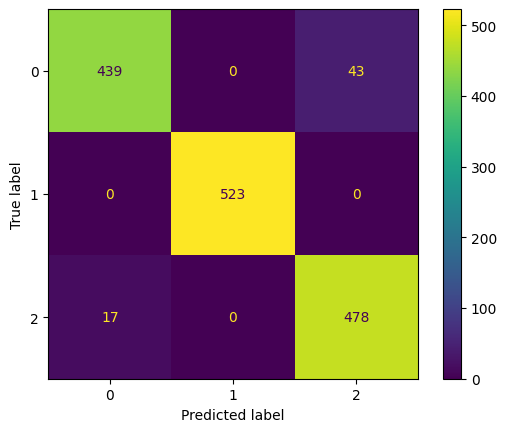

In [24]:
c_matrix_2 = confusion_matrix(y_true, y_pred_2)

confusion_matrix_display_2 = ConfusionMatrixDisplay(confusion_matrix = c_matrix_2, display_labels = [0, 1, 2])

confusion_matrix_display_2.plot()
plt.show()

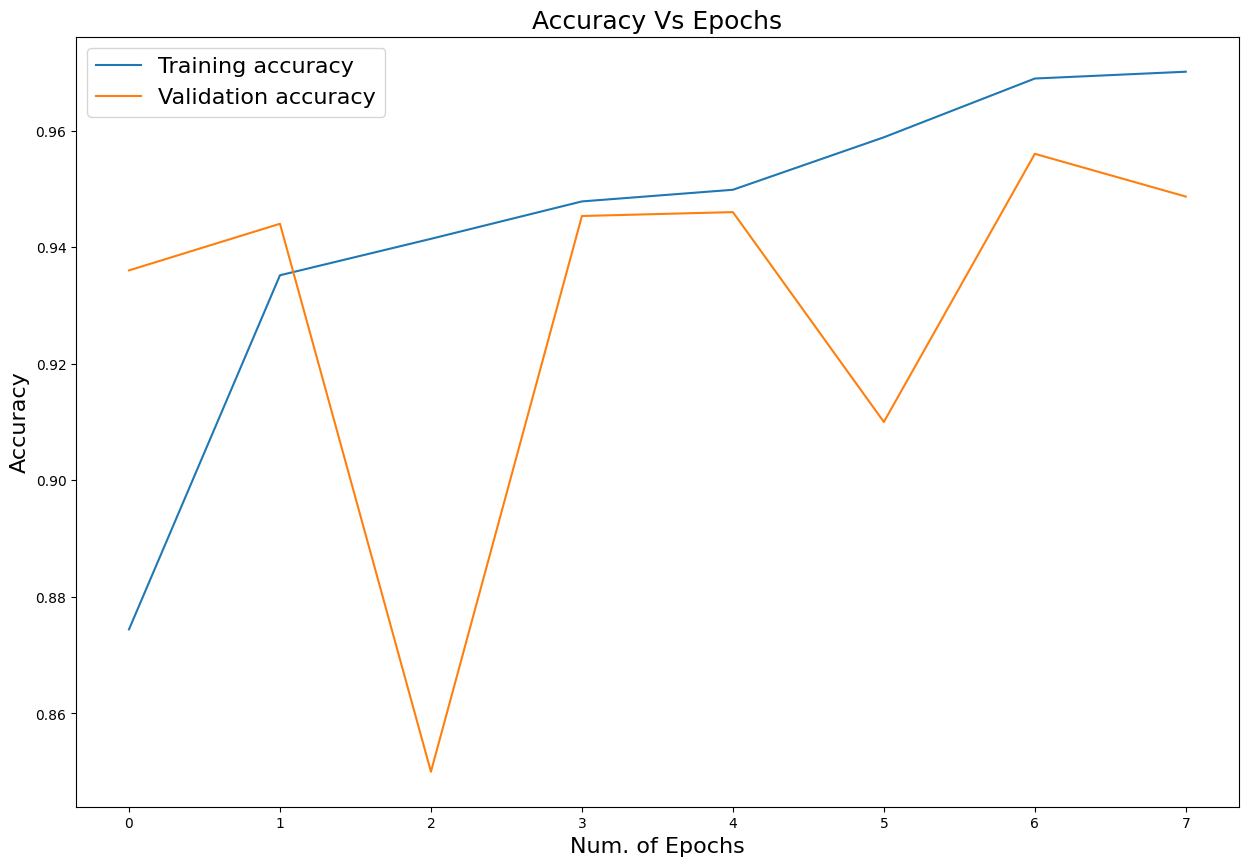

In [25]:
# Plotting line plot showing Accuracy vs Epochs Comparison for Train and Test Data

accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
plt.figure(figsize=(15, 10))
plt.plot(accuracy)
plt.plot(val_accuracy)

# Adding the title, legend and axis labels
plt.legend(['Training accuracy','Validation accuracy'], fontsize=16)
plt.title("Accuracy Vs Epochs", fontsize=18)
plt.xlabel("Num. of Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

# Displaying the plot
plt.show()

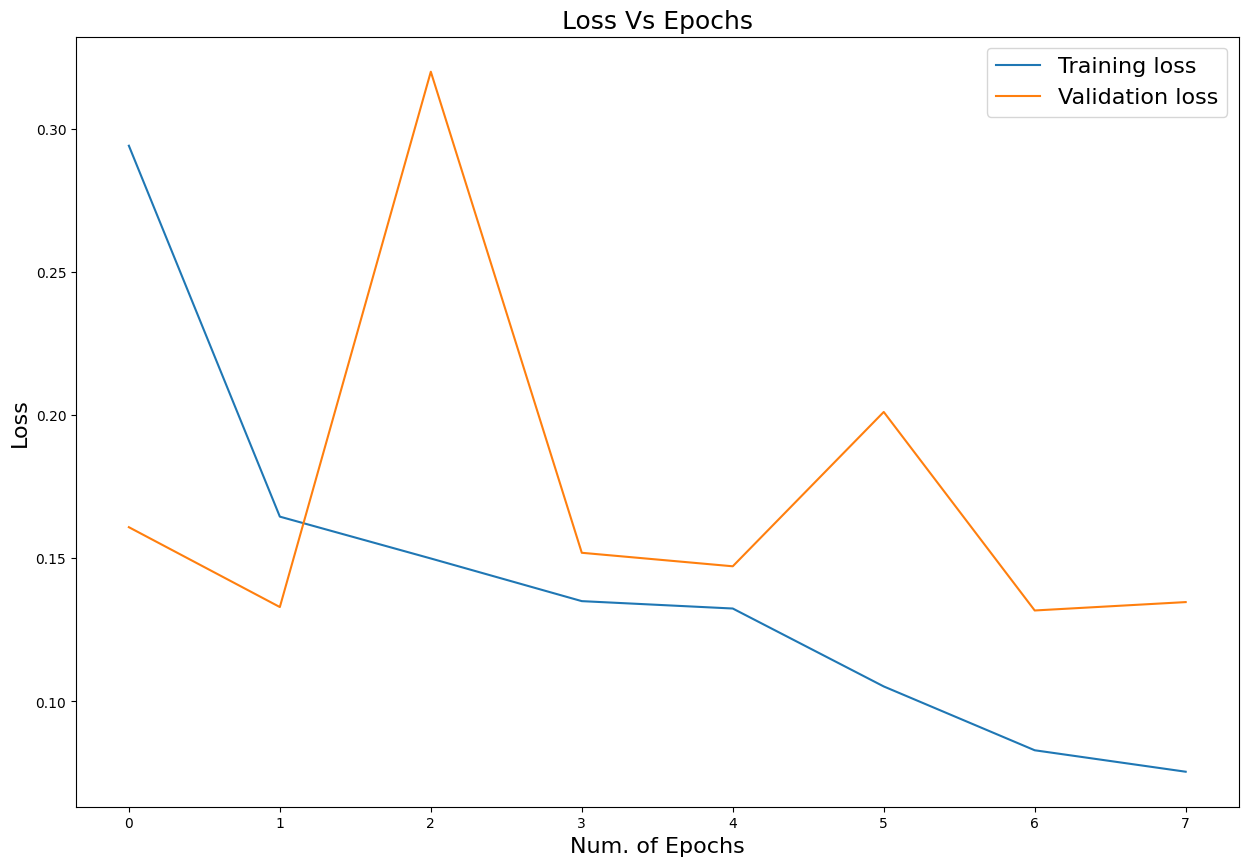

In [29]:
# Plotting line plot showing Accuracy vs Loss Comparison for Train and Test Data

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
plt.figure(figsize=(15, 10))
plt.plot(loss)
plt.plot(val_loss)

# Adding the title, legend and axis labels
plt.legend(['Training loss','Validation loss'], fontsize=16)
plt.title("Loss Vs Epochs", fontsize=18)
plt.xlabel("Num. of Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# Displaying the plot
plt.show()